<a href="https://colab.research.google.com/github/buksters/CLIPasso/blob/main/CLIPasso_walkthrough_creativeapp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CLIPasso**

Yael Vinker, Ehsan Pajouheshgar, Jessica Y. Bo, Roman Christian Bachmann,
Amit Haim Bermano, Daniel Cohen-Or, Amir Zamir, and Ariel Shamir. *Clipasso:
Semantically-aware object sketching*, 2022

Presented by Team 4: Alice Cai, Alexandra Steelman, and Ibuki Iwasaki


# What is CLIPasso?

CLIPasso is an object sketching method that creates a sketch from a target image using a defined number of Bezier curves with optimized control points in respect to a CLIP-based perceptual loss. By changing the number of curves (strokes), CLIPasso can create sketches of varying levels of abstraction while maintaining recognizability, underlying structure, and essential visual components of the subject drawn. You can see this for yourself below!

# (1) Install Dependencies and Clone the Repo

This stage might take a few minutes

*   Make sure your Hardware accelerator is set to GPU: Runtime > Change runtime type > Hardware Accelerator 
*   Make sure to **restart the runtime** after this stage is done





In [ ]:
%%capture

%cd /usr/local/
!pwd
!ls
!rm -rf cuda
!ln -s /usr/local/cuda-10.1 /usr/local/cuda
!stat cuda
!nvcc --version

%cd /content/
!git clone https://github.com/buksters/CLIPasso.git
%cd CLIPasso
!pip install -r requirements.txt
!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 -f https://download.pytorch.org/whl/torch_stable.html


In [ ]:
%%capture

%cd /content/CLIPasso
!git pull

!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

In [ ]:
%%capture

%cd /content/CLIPasso
!pip install git+https://github.com/openai/CLIP.git
!git clone https://github.com/BachiLi/diffvg
%cd diffvg
!git submodule update --init --recursive
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)
import sys
sys.path.append("/content/CLIPasso/diffvg/build/lib.linux-x86_64-3.7")
!pip3 install --upgrade Pillow
!python setup.py install

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# (2) Define your target image
 A few examples are already provided as well under "CLIPasso/target_images". You can also upload your own target image to sketch by placing the image in "CLIPasso/target_images" and specifying the name under "target_image".

# (3) Start Sketching 🎨

This stage will take a few minutes.

**Arguments:**<br>
* Target image: Insert the image filename as defined above.

**Optional arguments:**<br>

* **Mask object**: As previously stated, it is recommended to use images without a background, however, if your image contains a background, you can mask it out by using inserting 1 to "**mask_object**" field below. otherwise this value can be kept 0. 
* **Fix scale**: If your image is not squared, it might be cut off. In that case it is recommended to fill the "**fix_scale**" field with 1 to automatically fix the scale.
*  **Num_strokes**: You can define the abstraction level by using the "**num_strokes**" parameter. This parameter defines the number of strokes used to create the sketch. For example, optional values can be 32, 16, 8 and even 4.
* **num_sketches**: As stated in the paper, by default there will be three parallel running scripts to synthesize three sketches and automatically choose the best one. However, for some environments (for example when running on CPU) this might be slow, so you can specify --num_sketches 1 instead.

You can download the resulting sketch in SVG format from CLIPasso/output_sketches/\<target_image_name\>/best_iter.svg

/content/CLIPasso
Already up to date.


Downloading...
From: https://drive.google.com/uc?id=1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ
To: /content/CLIPasso/U2Net_/saved_models/u2net.pth
 78%|███████▊  | 137M/176M [00:01<00:00, 95.9MB/s]

Processing [capy.jpeg] ...


100%|██████████| 176M/176M [00:02<00:00, 84.2MB/s]


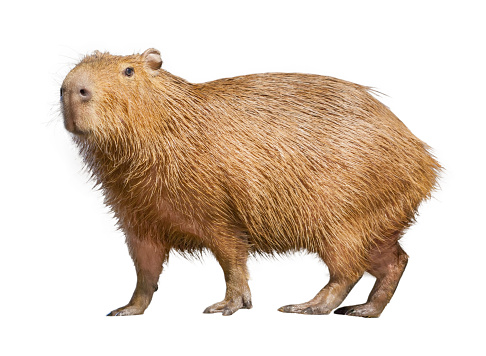

Results will be saved to 
[/content/CLIPasso/output_sketches/capy/] ...
GPU: True


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 153MB/s]
100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 84.3MiB/s]
100%|███████████████████████████████████████| 278M/278M [00:06<00:00, 48.3MiB/s]
100%|██████████| 2001/2001 [26:12<00:00,  1.27it/s]


In [ ]:
%cd /content/CLIPasso
!git pull

%matplotlib inline
target_image = "capy.jpeg" #@param {"type": "string"}
mask_object = 0 #@param {"type": "integer"}
fix_scale = 1 #@param {"type": "integer"}
num_strokes =  20#@param {type:"slider", min:4, max:64, step:1}
num_sketches =  3#@param {"type": "integer"}

%run run_object_sketching.py --target_file $target_image --num_sketches $num_sketches -colab --mask_object $mask_object --fix_scale $fix_scale --num_strokes $num_strokes

# (4) Display Results

/content/CLIPasso
Already up to date.


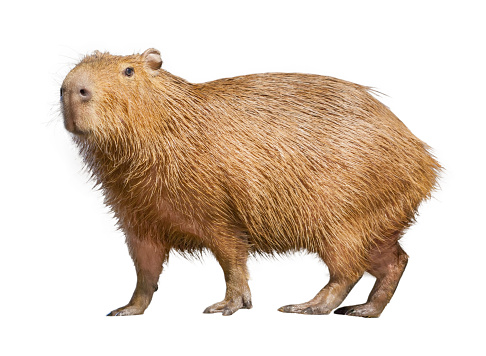

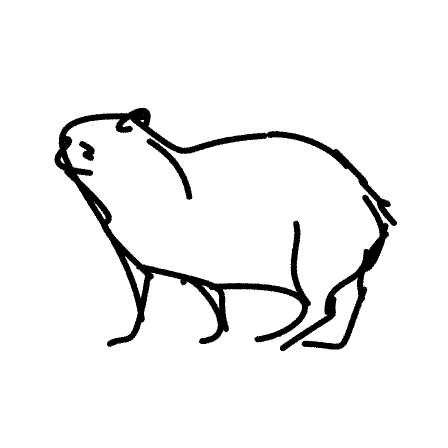

You can download the result sketch from /content/CLIPasso/output_sketches/capy/capy_20strokes_seed0/final_sketch.png
/content/CLIPasso/output_sketches/capy/capy_20strokes_seed0


In [ ]:
%cd /content/CLIPasso/
!git pull

target_image = "capy.jpeg" #@param {"type": "string"}
%run display_results.py --target_file $target_image

# (5) A bit more explanation

So how did it create that sketch? As demonstrated below, given the input image we provided (left), the model uses a saliency map produced by CLIP's vision transformer (center) to create a distribution map (right) with sampled initial strokes locations (the red dots). 

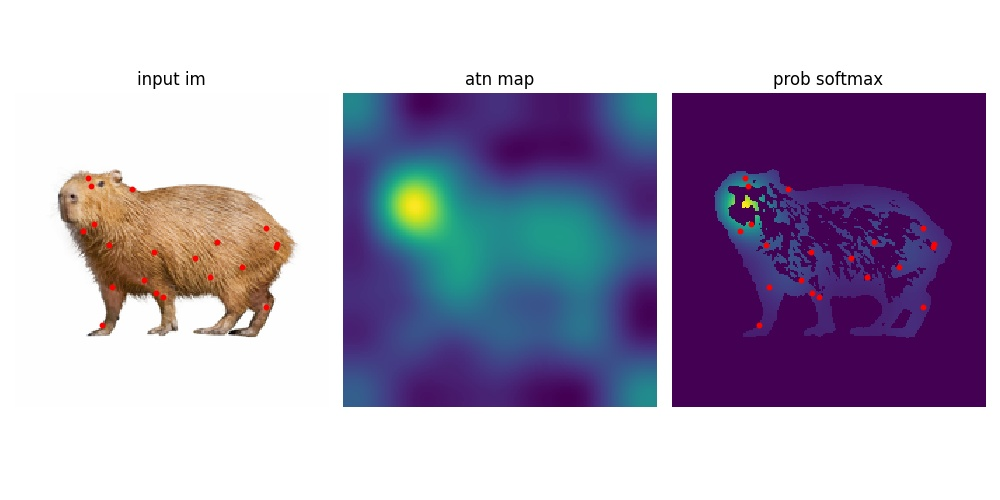

In [ ]:
#@title Saliency distribution
from IPython.display import Image 
import os
import re

abs_path = os.path.abspath(os.getcwd())
result_path = f"{abs_path}/output_sketches/{os.path.splitext(target_image)[0]}"
svg_files = os.listdir(result_path)
svg_files = [f for f in svg_files if "best.svg" in f]
p = re.compile("_best")
best_sketch_dir = ""
for m in p.finditer(svg_files[0]):
    best_sketch_dir += svg_files[0][0: m.start()]
cur_path = f"{result_path}/{best_sketch_dir}"
display(Image(f"{cur_path}/attention_map.jpg"))

Remember, we set num_strokes = 20! For more abstraction, use less strokes.


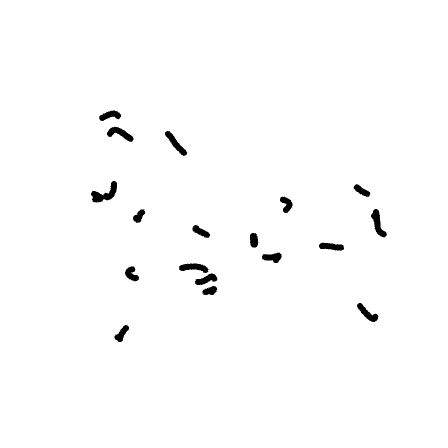

In [ ]:
#@title Initial strokes
print(f"Remember, we set num_strokes = {num_strokes}! For more abstraction, use less strokes.")
display(Image(f"{cur_path}/svg_to_png/iter_0000.png"))

Then,  in each step of the optimization the stroke parameters are fed to a differentiable rasterizer to produce a rasterized sketch. The resulting sketch, as well as the original image are then fed into CLIP to define a CLIP-based perceptual loss, which provides a combination of geometry and semantics. The model then back-propagates the loss through the differentiable rasterizer and updates the strokes’ control points directly at each step until convergence of the loss function.

# (6) Animation!
We can visualize the optimization process by compiling the intermediate iterations from the previous step into a short stop motion clip. The first frame shows the intialized bezier curves from the saliency map and then the control points are optimzied until convergence where the last frame is the outputted result. 

In [ ]:
%cd /content/CLIPasso/

import re
import os
import subprocess as sp
import moviepy.editor as mvp
from IPython.display import clear_output

target_image = "capy.jpeg" #@param {"type": "string"}

abs_path = os.path.abspath(os.getcwd())
result_path = f"{abs_path}/output_sketches/{os.path.splitext(target_image)[0]}"
svg_files = os.listdir(result_path)
svg_files = [f for f in svg_files if "best.svg" in f]

p = re.compile("_best")
best_sketch_dir = ""
for m in p.finditer(svg_files[0]):
    best_sketch_dir += svg_files[0][0: m.start()]

cur_path = f"{abs_path}/output_sketches/{os.path.splitext(target_image)[0]}/{best_sketch_dir}"
sp.run(["ffmpeg", "-y", "-framerate", "10", "-pattern_type", "glob", "-i", 
            f"{cur_path}/svg_to_png/iter_*.png", "-vb", "20M", f"{cur_path}/sketch.mp4"])

sp.run(["ffmpeg", "-y", "-i", f"{cur_path}/sketch.mp4", "-filter_complex",
    "[0]trim=0:2[hold];[0][hold]concat[extended];[extended][0]overlay",
    f"{cur_path}/sketch_longer.mp4"])

clear_output()
display(mvp.ipython_display(f"{cur_path}/sketch_longer.mp4"))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# (7) Creative application - CLIPasso draws you 👀

## TAKE PICTURE 📸

In [ ]:
#@title Setup
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo1.jpg', quality=0.8):
  %cd /content/CLIPasso/target_images
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

/content/CLIPasso/target_images


<IPython.core.display.Javascript object>

Saved to photo1.jpg


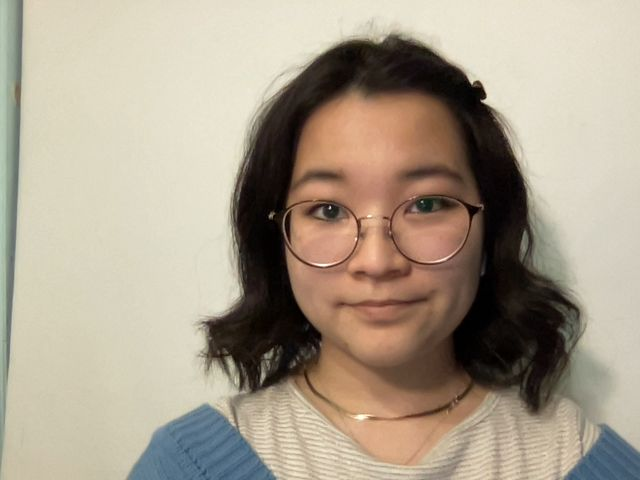

In [ ]:
#@title Capture photo
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

## MAKE DRAWING 🖊

/content/CLIPasso
Already up to date.
Processing [photo1.jpg] ...


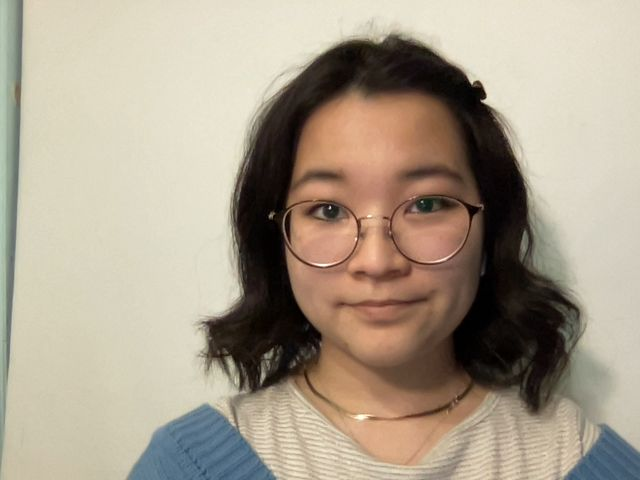

Results will be saved to 
[/content/CLIPasso/output_sketches/photo1/] ...
GPU: True


100%|██████████| 2001/2001 [26:23<00:00,  1.26it/s]


In [ ]:
%cd /content/CLIPasso
!git pull

%matplotlib inline
target_image = "photo1.jpg" #@param {"type": "string"}
mask_object = 1 #@param {"type": "integer"}
fix_scale = 1 #@param {"type": "integer"}
num_strokes =  20#@param {"type": "integer"}
num_sketches =  2#@param {"type": "integer"}

%run run_object_sketching.py --target_file $target_image --num_sketches $num_sketches -colab --mask_object $mask_object --fix_scale $fix_scale --num_strokes $num_strokes

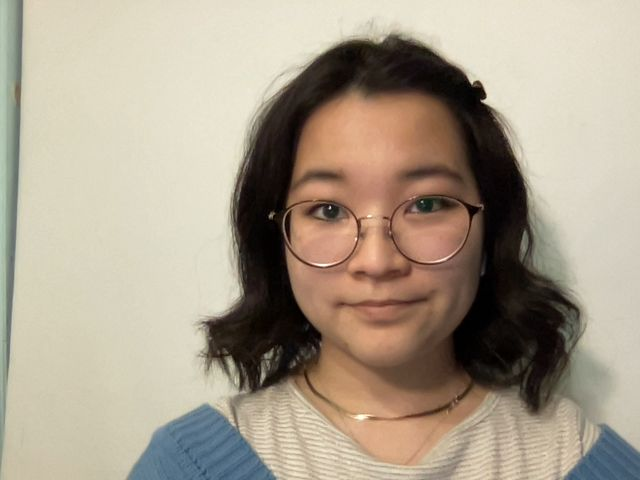

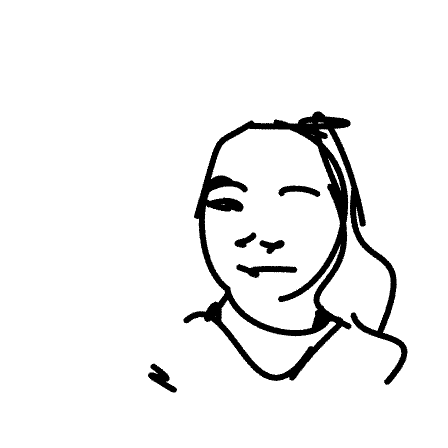

You can download the result sketch from /content/CLIPasso/output_sketches/photo1/photo1_20strokes_seed1000/final_sketch.png
/content/CLIPasso/output_sketches/photo1/photo1_20strokes_seed1000


In [ ]:
# %cd /content/CLIPasso/
# !git pull

# target_image = "photo.jpg" #@param {"type": "string"}
%run display_results.py --target_file $target_image

In [ ]:
#@title Optimization animation
%cd /content/CLIPasso/

import re
import os
import subprocess as sp
import moviepy.editor as mvp
from IPython.display import clear_output

# target_image = "photo.jpg" #@param {"type": "string"}

abs_path = os.path.abspath(os.getcwd())
result_path = f"{abs_path}/output_sketches/{os.path.splitext(target_image)[0]}"
svg_files = os.listdir(result_path)
svg_files = [f for f in svg_files if "best.svg" in f]

p = re.compile("_best")
best_sketch_dir = ""
for m in p.finditer(svg_files[0]):
    best_sketch_dir += svg_files[0][0: m.start()]

cur_path = f"{abs_path}/output_sketches/{os.path.splitext(target_image)[0]}/{best_sketch_dir}"
sp.run(["ffmpeg", "-y", "-framerate", "10", "-pattern_type", "glob", "-i", 
            f"{cur_path}/svg_to_png/iter_*.png", "-vb", "20M", f"{cur_path}/sketch.mp4"])

sp.run(["ffmpeg", "-y", "-i", f"{cur_path}/sketch.mp4", "-filter_complex",
    "[0]trim=0:2[hold];[0][hold]concat[extended];[extended][0]overlay",
    f"{cur_path}/sketch_longer.mp4"])

clear_output()
display(mvp.ipython_display(f"{cur_path}/sketch_longer.mp4"))